In [0]:
import pandas as pd
import numpy as np


In [0]:
#create the Y labels based on the 12,500 positive examples first followed by 12,500 negative examples
labels =[]
i = 0
for i in range (25000):
    if i<=12499:
        labels.append(1)
    else:
        labels.append(0)

labels =np.array(labels)
print(labels)

[1 1 1 ... 0 0 0]


In [0]:
from google.colab import files
uploaded = files.upload()

Saving full_train.txt to full_train.txt


In [0]:
#read the txt file using pandas splitting rows by new line 
#for juypter notbook
#train = pd.read_csv('full_train.txt', sep = "\n", header=None)
import io
import pandas as pd
#read data for colab
train = pd.read_csv(io.StringIO(uploaded["full_train.txt"].decode("utf-8")),sep ="\n", header = None)

In [0]:
#rename panadas columns
train['labels'] = labels
train =train.rename(columns={0:"Review", "labels" :"Labels"})

#use panadas to split the reviews and labels, converting to numpy arrays
X= train.iloc[:,0].values
Y = train.iloc[:,1].values




In [0]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [0]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from nltk.stem.porter import PorterStemmer


#method used to preprocess the data set
def preprocess(dataset): 
    
    #convert the sentences to word tokens
    tokens = word_tokenize(dataset)
    
    # convert to lower case
    tokens = [w.lower() for w in tokens]
    
    # remove punctuation from each word
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    
    # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    
        
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
        
    #stem each word
    porter = PorterStemmer()
    stemmed = [porter.stem(word) for word in words]
    
    
    #join all the word tokens back into single sentence
    stemmed = " ".join(stemmed)
    
        
    return stemmed



In [0]:
preprocessed_sentences = []
for sentence in X:
    
    new_sentence = preprocess(sentence)
    preprocessed_sentences.append(new_sentence)

In [0]:
from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding
from keras.preprocessing.text import Tokenizer,text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

text_tokenizer = Tokenizer()
text_tokenizer.fit_on_texts(preprocessed_sentences)
word_dict = text_tokenizer.word_index # Assigning unique integer to each word in input text
X_RNN = text_tokenizer.texts_to_sequences(preprocessed_sentences)


{'br': 1, 'movi': 2, 'film': 3, 'nt': 4, 'one': 5, 'like': 6, 'time': 7, 'good': 8, 'make': 9, 'get': 10, 'charact': 11, 'see': 12, 'watch': 13, 'would': 14, 'stori': 15, 'even': 16, 'realli': 17, 'scene': 18, 'well': 19, 'show': 20, 'look': 21, 'much': 22, 'end': 23, 'could': 24, 'peopl': 25, 'bad': 26, 'also': 27, 'go': 28, 'great': 29, 'first': 30, 'think': 31, 'love': 32, 'way': 33, 'play': 34, 'act': 35, 'thing': 36, 'made': 37, 'know': 38, 'say': 39, 'seem': 40, 'work': 41, 'plot': 42, 'actor': 43, 'two': 44, 'mani': 45, 'come': 46, 'seen': 47, 'want': 48, 'take': 49, 'never': 50, 'year': 51, 'littl': 52, 'best': 53, 'tri': 54, 'life': 55, 'ever': 56, 'give': 57, 'better': 58, 'man': 59, 'still': 60, 'perform': 61, 'find': 62, 'feel': 63, 'part': 64, 'use': 65, 'actual': 66, 'someth': 67, 'back': 68, 'interest': 69, 'director': 70, 'lot': 71, 'real': 72, 'though': 73, 'cast': 74, 'enjoy': 75, 'live': 76, 'anoth': 77, 'noth': 78, 'guy': 79, 'new': 80, 'role': 81, 'funni': 82, 'mus

In [0]:
num_source_tokens = len(text_tokenizer.word_index)
max_source_seq_length = max(len(text_to_word_sequence(x)) for x in preprocessed_sentences)
print(num_source_tokens)
print(max_source_seq_length)

68726
1440


In [0]:
#pad each sequence with 0's until max length
X_RNN = pad_sequences(X_RNN)

In [0]:
num_source_tokens = len(text_tokenizer.word_index)
max_source_seq_length = max(len(text_to_word_sequence(x)) for x in preprocessed_sentences)
print(num_source_tokens)
print(max_source_seq_length)

68726
1440


In [0]:
from sklearn.model_selection import train_test_split
y_RNN = Y
X_RNN_train, X_RNN_test, y_RNN_train, y_RNN_test = train_test_split(X_RNN,y_RNN, train_size =0.9) 
print(len(X_RNN_train))
#splitting data into training data and test data
# again i have chosen an 80/20 split for this

22500


In [0]:
from keras import optimizers

#create acceptor RNN model to classify tweets using tensorflow
#3 layers the original embedding, LSTM layer and output layer
import tensorflow as tf
model = tf.keras.Sequential([
    #size of vocab and output dimensions
    tf.keras.layers.Embedding(70000, 256,input_length=1440),
    #LSTM with 128 nodes
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    #dense output layer binary therefore only 1
    tf.keras.layers.Dense(1)
])
#compile as binary output with Stochastic gradient descent optimiser, comparing accuracy for each epoch
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer='sgd',
              metrics=['accuracy'])
#give summary of model
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 1440, 256)         17920000  
_________________________________________________________________
bidirectional_4 (Bidirection (None, 256)               394240    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 18,314,497
Trainable params: 18,314,497
Non-trainable params: 0
_________________________________________________________________


In [0]:
#train the model over 100 epochs in batchs of 64 
epochs = 100
Batch_size = 64
history = model.fit(x=X_RNN_train,y=y_RNN_train, batch_size=Batch_size, epochs=epochs,validation_split=0.2)

Epoch 1/100
282/282 [==============================] - 69s 243ms/step - loss: 0.6932 - accuracy: 0.5002 - val_loss: 0.6932 - val_accuracy: 0.4984
Epoch 2/100
282/282 [==============================] - 68s 240ms/step - loss: 0.6930 - accuracy: 0.5002 - val_loss: 0.6931 - val_accuracy: 0.4984
Epoch 3/100
282/282 [==============================] - 67s 238ms/step - loss: 0.6929 - accuracy: 0.5002 - val_loss: 0.6930 - val_accuracy: 0.4984
Epoch 4/100
282/282 [==============================] - 67s 238ms/step - loss: 0.6928 - accuracy: 0.5002 - val_loss: 0.6929 - val_accuracy: 0.4984
Epoch 5/100
282/282 [==============================] - 67s 237ms/step - loss: 0.6926 - accuracy: 0.5002 - val_loss: 0.6928 - val_accuracy: 0.4984
Epoch 6/100
282/282 [==============================] - 67s 237ms/step - loss: 0.6926 - accuracy: 0.5002 - val_loss: 0.6926 - val_accuracy: 0.4984
Epoch 7/100
282/282 [==============================] - 67s 236ms/step - loss: 0.6924 - accuracy: 0.5002 - val_loss: 0.6926 -

In [0]:
#evaluate model with test data
results = model.evaluate(x= X_RNN_test, y=y_RNN_test)
print('test loss, test acc:', results)

79/79 [==============================] - 4s 54ms/step - loss: 0.3352 - accuracy: 0.8764
test loss, test acc: [0.3352072238922119, 0.8763999938964844]


In [0]:
#save mdoel as h5 file
model.save("movie_reviewer.h5")

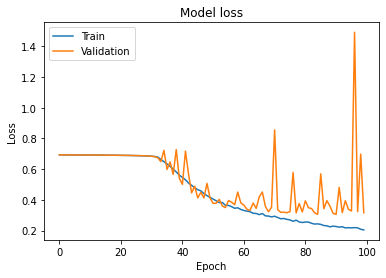

In [0]:
import matplotlib.pyplot as plt

#Plotting loss, after training model of validation and train
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.show()

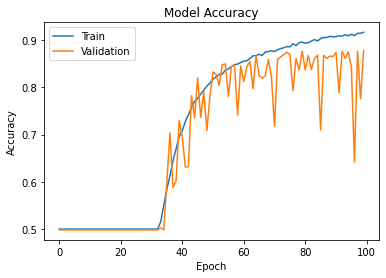

In [0]:
#plot accuracy of model for train and validation
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.show()

In [0]:
model = tf.keras.models.load_model('movie_reviewer.h5')

In [0]:
#created a reverse dictionary to show the classified sentence with the label, but as the stopwords were removed it makes no sense
#to read and therefore this test wasnt completed
reverse_input_word_dict = dict(
  (i, word) for word, i in word_dict.items())

{1: 'br', 2: 'movi', 3: 'film', 4: 'nt', 5: 'one', 6: 'like', 7: 'time', 8: 'good', 9: 'make', 10: 'get', 11: 'charact', 12: 'see', 13: 'watch', 14: 'would', 15: 'stori', 16: 'even', 17: 'realli', 18: 'scene', 19: 'well', 20: 'show', 21: 'look', 22: 'much', 23: 'end', 24: 'could', 25: 'peopl', 26: 'bad', 27: 'also', 28: 'go', 29: 'great', 30: 'first', 31: 'think', 32: 'love', 33: 'way', 34: 'play', 35: 'act', 36: 'thing', 37: 'made', 38: 'know', 39: 'say', 40: 'seem', 41: 'work', 42: 'plot', 43: 'actor', 44: 'two', 45: 'mani', 46: 'come', 47: 'seen', 48: 'want', 49: 'take', 50: 'never', 51: 'year', 52: 'littl', 53: 'best', 54: 'tri', 55: 'life', 56: 'ever', 57: 'give', 58: 'better', 59: 'man', 60: 'still', 61: 'perform', 62: 'find', 63: 'feel', 64: 'part', 65: 'use', 66: 'actual', 67: 'someth', 68: 'back', 69: 'interest', 70: 'director', 71: 'lot', 72: 'real', 73: 'though', 74: 'cast', 75: 'enjoy', 76: 'live', 77: 'anoth', 78: 'noth', 79: 'guy', 80: 'new', 81: 'role', 82: 'funni', 83: 

In [0]:
print(X_RNN_test[0])
decoded_sentence = []
for element in X_RNN_test[0]:
  if element ==0:
    pass
  else:
    word = reverse_input_word_dict[element]
    decoded_sentence.append(word)
print(decoded_sentence)

[   0    0    0 ... 2733 2083  887]
['one', 'disturb', 'tragic', 'period', 'american', 'histori', 'began', 'member', 'summer', 'love', 'cultur', 'end', 'seventi', 'onset', 'eventu', 'tool', 'old', 'love', 'bead', 'night', 'parti', 'evolv', 'back', 'mainstream', 'life', 'whatev', 'meant', 'could', 'grow', 'youth', 'sometim', 'irrat', 'exuber', 'cultur', 'wonderland', 'love', 'drug', 'sens', 'entitl', 'coupl', 'distast', 'author', 'valu', 'establish', 'world', 'film', 'captur', 'br', 'br', 'sixti', 'time', 'revolut', 'violent', 'chang', 'tore', 'american', 'hous', 'apart', 'battl', 'deal', 'aftermath', 'carnag', 'charact', 'wonderland', 'hous', 'icon', 'misfit', 'seventi', 'part', 'biker', 'part', 'hippi', 'part', 'crook', 'outcast', 'ideolog', 'express', 'sens', 'dissatisfact', 'everyth', 'allegi', 'noth', 'ron', 'billi', 'david', 'fanci', 'sort', 'robin', 'hood', 'dope', 'talk', 'love', 'behav', 'violent', 'take', 'rich', 'sell', 'misbegotten', 'steal', 'everyon', 'br', 'br', 'holm', '